In [1]:
# 국내 프로야구선수 연봉 예측
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

In [2]:
# Data Source : http://www.statiz.co.kr/

picher_file_path = '../data/csv/picher_stats_2017.csv'
batter_file_path = '../data/csv/batter_stats_2017.csv'
picher = pd.read_csv(picher_file_path)
batter = pd.read_csv(batter_file_path)

In [3]:
picher.columns

Index(['선수명', '팀명', '승', '패', '세', '홀드', '블론', '경기', '선발', '이닝', '삼진/9',
       '볼넷/9', '홈런/9', 'BABIP', 'LOB%', 'ERA', 'RA9-WAR', 'FIP', 'kFIP', 'WAR',
       '연봉(2018)', '연봉(2017)'],
      dtype='object')

In [4]:
picher.head()

,선수명,팀명,승,패,세,홀드,블론,경기,선발,이닝,...,홈런/9,BABIP,LOB%,ERA,RA9-WAR,FIP,kFIP,WAR,연봉(2018),연봉(2017)
0,켈리,SK,16,7,0,0,0,30,30,190.0,...,0.76,0.342,73.7,3.60,6.91,3.69,3.44,6.62,140000,85000
1,소사,LG,11,11,1,0,0,30,29,185.1,...,0.53,0.319,67.1,3.88,6.80,3.52,3.41,6.08,120000,50000
2,양현종,KIA,20,6,0,0,0,31,31,193.1,...,0.79,0.332,72.1,3.44,6.54,3.94,3.82,5.64,230000,150000
3,차우찬,LG,10,7,0,0,0,28,28,175.2,...,1.02,0.298,75.0,3.43,6.11,4.20,4.03,4.63,100000,100000
4,레일리,롯데,13,7,0,0,0,30,30,187.1,...,0.91,0.323,74.1,3.80,6.13,4.36,4.31,4.38,111000,85000


In [5]:
print(picher.shape)

(152, 22)


In [6]:
import matplotlib as mpl
set(sorted([f.name for f in mpl.font_manager.fontManager.ttflist])) # 현재 OS 내에 설치된 폰트를 확인합니다.

{'Agency FB',
 'Algerian',
 'Ami R',
 'Arial',
 'Arial Rounded MT Bold',
 'Bahnschrift',
 'Baskerville Old Face',
 'Batang',
 'Bauhaus 93',
 'Bell MT',
 'Berlin Sans FB',
 'Berlin Sans FB Demi',
 'Bernard MT Condensed',
 'Blackadder ITC',
 'Bodoni MT',
 'Book Antiqua',
 'Bookman Old Style',
 'Bookshelf Symbol 7',
 'Bradley Hand ITC',
 'Britannic Bold',
 'Broadway',
 'Brush Script MT',
 'Calibri',
 'Californian FB',
 'Calisto MT',
 'Cambria',
 'Candara',
 'Castellar',
 'Centaur',
 'Century',
 'Century Gothic',
 'Century Schoolbook',
 'Chiller',
 'Colonna MT',
 'Comic Sans MS',
 'Consolas',
 'Constantia',
 'Cooper Black',
 'Copperplate Gothic Bold',
 'Copperplate Gothic Light',
 'Corbel',
 'Courier New',
 'Curlz MT',
 'DejaVu Sans',
 'DejaVu Sans Display',
 'DejaVu Sans Mono',
 'DejaVu Serif',
 'DejaVu Serif Display',
 'Ebrima',
 'Edwardian Script ITC',
 'Elephant',
 'Engravers MT',
 'Eras Bold ITC',
 'Eras Demi ITC',
 'Eras Light ITC',
 'Eras Medium ITC',
 'Felix Titling',
 'Footlight M

In [7]:
mpl.rc('font', family='Malgun Gothic') # 자신의 OS에 존재하는 한글 폰트를 선택합니다. 없는경우, 위의 링크에서 한글폰트 설치 후 실행합니다.

In [8]:
picher['연봉(2018)'].describe()

count       152.000000
mean      18932.236842
std       30940.732924
min        2700.000000
25%        4000.000000
50%        7550.000000
75%       18500.000000
max      230000.000000
Name: 연봉(2018), dtype: float64

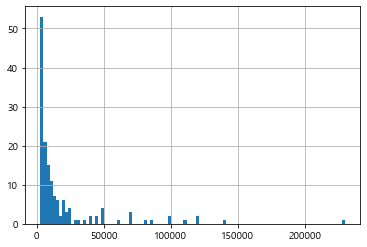

In [9]:
picher['연봉(2018)'].hist(bins=100) # 2018년 연봉 분포를 출력합니다.

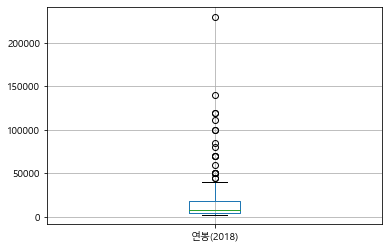

In [10]:
picher.boxplot(column=['연봉(2018)']) # 연봉의 Boxplot을 출력합니다.

In [11]:
picher_features_df = picher[['승', '패', '세', '홀드', '블론', '경기', '선발', '이닝', '삼진/9',
       '볼넷/9', '홈런/9', 'BABIP', 'LOB%', 'ERA', 'RA9-WAR', 'FIP', 'kFIP', 'WAR',
       '연봉(2018)', '연봉(2017)']]

In [12]:
# 피처 각각에 대한 histogram을 출력합니다.
def plot_hist_each_column(df):
    plt.rcParams['figure.figsize'] = [20, 16]
    fig = plt.figure(1)
    
    # df의 column 갯수 만큼의 subplot을 출력합니다.
    for i in range(len(df.columns)):
        ax = fig.add_subplot(5, 5, i+1)
        plt.hist(df[df.columns[i]], bins=50)
        ax.set_title(df.columns[i])
    plt.show()

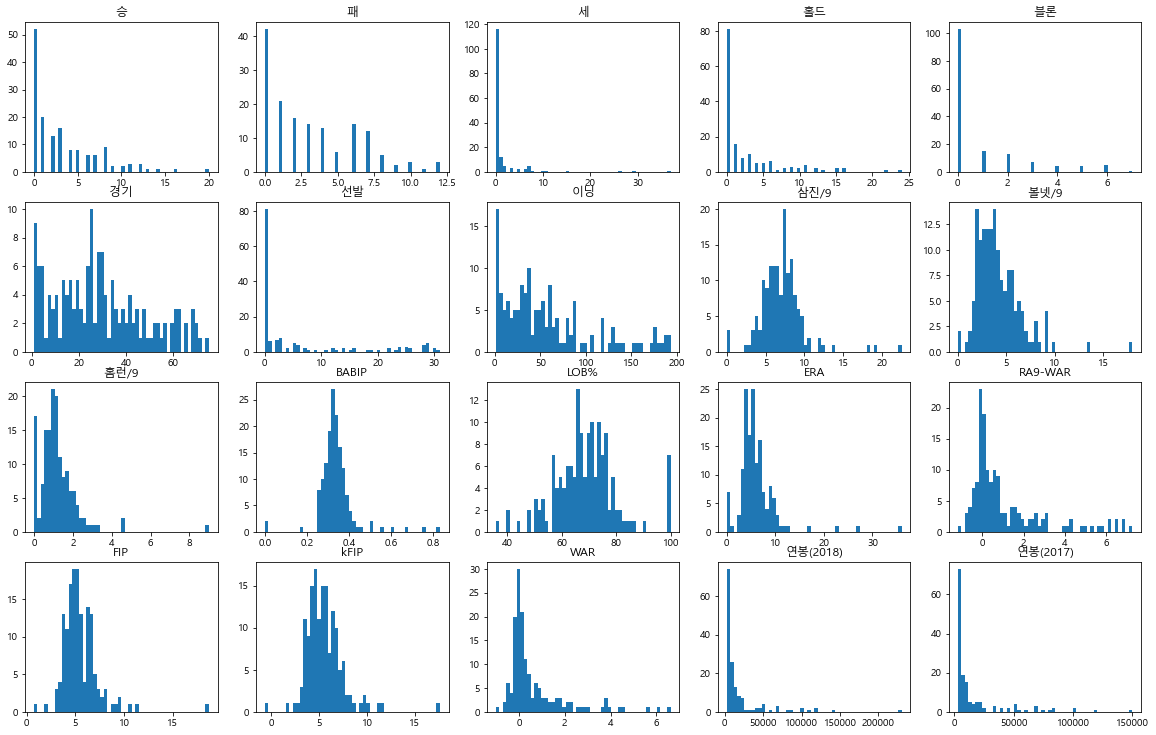

In [13]:
plot_hist_each_column(picher_features_df)

In [14]:
# 투수 연봉 예측하기
# pandas 형태로 정의된 데이터를 출력할 때, scientific-notation이 아닌 float 모양으로 출력되게 해줍니다.
pd.options.mode.chained_assignment = None

In [15]:
# 피처 각각에 대한 scaling을 수행하는 함수를 정의합니다.
def standard_scaling(df, scale_columns):
    for col in scale_columns:
        series_mean = df[col].mean()
        series_std = df[col].std()
        df[col] = df[col].apply(lambda x: (x-series_mean)/series_std)
    return df

In [16]:
# 피처 각각에 대한 scaling을 수행합니다.
scale_columns = ['승', '패', '세', '홀드', '블론', '경기', '선발', '이닝', '삼진/9',
       '볼넷/9', '홈런/9', 'BABIP', 'LOB%', 'ERA', 'RA9-WAR', 'FIP', 'kFIP', 'WAR', '연봉(2017)']
picher_df = standard_scaling(picher, scale_columns)

In [17]:
picher_df = picher_df.rename(columns={'연봉(2018)': 'y'})
picher_df.head(5)

,선수명,팀명,승,패,세,홀드,블론,경기,선발,이닝,...,홈런/9,BABIP,LOB%,ERA,RA9-WAR,FIP,kFIP,WAR,y,연봉(2017)
0,켈리,SK,3.313623,1.227145,-0.306452,-0.585705,-0.543592,0.059433,2.452068,2.645175,...,-0.442382,0.016783,0.446615,-0.587056,3.174630,-0.971030,-1.058125,4.503142,140000,2.734705
1,소사,LG,2.019505,2.504721,-0.098502,-0.585705,-0.543592,0.059433,2.349505,2.547755,...,-0.668521,-0.241686,-0.122764,-0.519855,3.114968,-1.061888,-1.073265,4.094734,120000,1.337303
2,양현종,KIA,4.348918,0.907751,-0.306452,-0.585705,-0.543592,0.111056,2.554632,2.706808,...,-0.412886,-0.095595,0.308584,-0.625456,2.973948,-0.837415,-0.866361,3.761956,230000,5.329881
3,차우찬,LG,1.760682,1.227145,-0.306452,-0.585705,-0.543592,-0.043811,2.246942,2.350927,...,-0.186746,-0.477680,0.558765,-0.627856,2.740722,-0.698455,-0.760385,2.998081,100000,3.333592
4,레일리,롯데,2.537153,1.227145,-0.306452,-0.585705,-0.543592,0.059433,2.452068,2.587518,...,-0.294900,-0.196735,0.481122,-0.539055,2.751570,-0.612941,-0.619085,2.809003,111000,2.734705


In [18]:
# 팀명 피처를 one-hot encoding으로 변환합니다.
team_encoding = pd.get_dummies(picher_df['팀명'])
picher_df = picher_df.drop('팀명', axis=1)
picher_df = picher_df.join(team_encoding)

In [19]:
team_encoding.head(5)

,KIA,KT,LG,NC,SK,두산,롯데,삼성,한화
0,0,0,0,0,1,0,0,0,0
1,0,0,1,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0
3,0,0,1,0,0,0,0,0,0
4,0,0,0,0,0,0,1,0,0


In [20]:
picher_df.head()

,선수명,승,패,세,홀드,블론,경기,선발,이닝,삼진/9,...,연봉(2017),KIA,KT,LG,NC,SK,두산,롯데,삼성,한화
0,켈리,3.313623,1.227145,-0.306452,-0.585705,-0.543592,0.059433,2.452068,2.645175,0.672099,...,2.734705,0,0,0,0,1,0,0,0,0
1,소사,2.019505,2.504721,-0.098502,-0.585705,-0.543592,0.059433,2.349505,2.547755,0.134531,...,1.337303,0,0,1,0,0,0,0,0,0
2,양현종,4.348918,0.907751,-0.306452,-0.585705,-0.543592,0.111056,2.554632,2.706808,0.109775,...,5.329881,1,0,0,0,0,0,0,0,0
3,차우찬,1.760682,1.227145,-0.306452,-0.585705,-0.543592,-0.043811,2.246942,2.350927,0.350266,...,3.333592,0,0,1,0,0,0,0,0,0
4,레일리,2.537153,1.227145,-0.306452,-0.585705,-0.543592,0.059433,2.452068,2.587518,0.155751,...,2.734705,0,0,0,0,0,0,1,0,0


In [21]:
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from math import sqrt

# 학습 데이터와 테스트 데이터로 분리합니다.
X = picher_df[picher_df.columns.difference(['선수명', 'y'])]
y = picher_df['y']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=19)

In [22]:
# 회귀 분석 계수를 학습합니다 (회귀 모델 학습)
lr = linear_model.LinearRegression()
model = lr.fit(X_train, y_train)

In [23]:
# 학습된 계수를 출력합니다.
print(lr.coef_)

[ -1481.01733901   -416.68736601 -94136.23649209  -1560.86205158
   1572.00472193   -747.04952389  -1375.53830289   -523.54687556
   3959.10653661    898.37638984  10272.48746451  77672.53804469
  -2434.38947427   -892.11801281    449.91117164   7612.15661812
   1271.04500059  -2810.5564514    5396.97279896  -4797.30275904
   -250.69773139    236.02530053  19130.59021357    854.02604585
   1301.61974637   3613.84063182   -935.07281796  18144.60099745]


In [24]:
picher_df.columns

Index(['선수명', '승', '패', '세', '홀드', '블론', '경기', '선발', '이닝', '삼진/9', '볼넷/9',
       '홈런/9', 'BABIP', 'LOB%', 'ERA', 'RA9-WAR', 'FIP', 'kFIP', 'WAR', 'y',
       '연봉(2017)', 'KIA', 'KT', 'LG', 'NC', 'SK', '두산', '롯데', '삼성', '한화'],
      dtype='object')

In [25]:
import statsmodels.api as sm

# statsmodel 라이브러리로 회귀 분석을 수행합니다.
X_train = sm.add_constant(X_train)
model = sm.OLS(y_train, X_train).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.928
Model:                            OLS   Adj. R-squared:                  0.907
Method:                 Least Squares   F-statistic:                     44.19
Date:                Mon, 30 Nov 2020   Prob (F-statistic):           7.70e-42
Time:                        15:16:39   Log-Likelihood:                -1247.8
No. Observations:                 121   AIC:                             2552.
Df Residuals:                      93   BIC:                             2630.
Df Model:                          27                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.678e+04    697.967     24.036      0.000    1.54e+04    1.82e+04
BABIP      -1481.0173   1293.397     -1.145      0.255   -4049.448    1087.414
ERA         -416.6874   2322.402     -0.179      0.858   -5028.517    4195.143
FIP        -9.414e+04   9.43e+04     -0.998      0.321   -2.81e+05    9.31e+04
KIA          303.1852   2222.099      0.136      0.892   -4109.462    4715.833
KT          3436.0520   2133.084      1.611      0.111    -799.831    7671.935
LG          1116.9978   2403.317      0.465      0.643   -3655.513    5889.509
LOB%       -1375.5383   1564.806     -0.879      0.382   -4482.933    1731.857
NC          1340.5004   2660.966      0.504      0.616   -3943.651    6624.652
RA9-WAR     3959.1065   2931.488      1.351      0.180   -1862.247    9780.460
SK          2762.4237   2243.540      1.231      0.221   -1692.803    7217.650
WAR         1.027e+04   2532.309      4.057      0.000    5243.823    1.53e+04
kFIP        7.767e+04   7.95e+04      0.977      0.331   -8.03e+04    2.36e+05
경기         -2434.3895   2953.530     -0.824      0.412   -8299.515    3430.736
두산           971.9293   2589.849      0.375      0.708   -4170.998    6114.857
롯데          2313.9585   2566.009      0.902      0.370   -2781.627    7409.544
볼넷/9        7612.1566   6275.338      1.213      0.228   -4849.421    2.01e+04
블론          1271.0450   1242.128      1.023      0.309   -1195.576    3737.666
삼성          -946.5092   2482.257     -0.381      0.704   -5875.780    3982.762
삼진/9        5396.9728   7286.221      0.741      0.461   -9072.019    1.99e+04
선발         -4797.3028   5489.352     -0.874      0.384   -1.57e+04    6103.463
세           -250.6977   1295.377     -0.194      0.847   -2823.059    2321.663
승            236.0253   2215.264      0.107      0.915   -4163.049    4635.100
연봉(2017)    1.913e+04   1270.754     15.055      0.000    1.66e+04    2.17e+04
이닝           854.0260   6623.940      0.129      0.898   -1.23e+04     1.4e+04
패           1301.6197   1935.935      0.672      0.503   -2542.763    5146.003
한화          5477.8879   2184.273      2.508      0.014    1140.355    9815.421
홀드          -935.0728   1637.923     -0.571      0.569   -4187.663    2317.518
홈런/9        1.814e+04   1.68e+04      1.082      0.282   -1.52e+04    5.14e+04
==============================================================================
Omnibus:                       28.069   Durbin-Watson:                   2.025
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              194.274
Skew:                          -0.405   Prob(JB):                     6.52e-43
Kurtosis:                       9.155   Cond. No.                     3.44e+16
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is

[Text(0, 0, 'const'),
 Text(0, 0, 'BABIP'),
 Text(0, 0, 'ERA'),
 Text(0, 0, 'FIP'),
 Text(0, 0, 'KIA'),
 Text(0, 0, 'KT'),
 Text(0, 0, 'LG'),
 Text(0, 0, 'LOB%'),
 Text(0, 0, 'NC'),
 Text(0, 0, 'RA9-WAR'),
 Text(0, 0, 'SK'),
 Text(0, 0, 'WAR'),
 Text(0, 0, 'kFIP'),
 Text(0, 0, '경기'),
 Text(0, 0, '두산'),
 Text(0, 0, '롯데'),
 Text(0, 0, '볼넷/9'),
 Text(0, 0, '블론'),
 Text(0, 0, '삼성'),
 Text(0, 0, '삼진/9'),
 Text(0, 0, '선발'),
 Text(0, 0, '세'),
 Text(0, 0, '승'),
 Text(0, 0, '연봉(2017)'),
 Text(0, 0, '이닝'),
 Text(0, 0, '패'),
 Text(0, 0, '한화'),
 Text(0, 0, '홀드'),
 Text(0, 0, '홈런/9')]

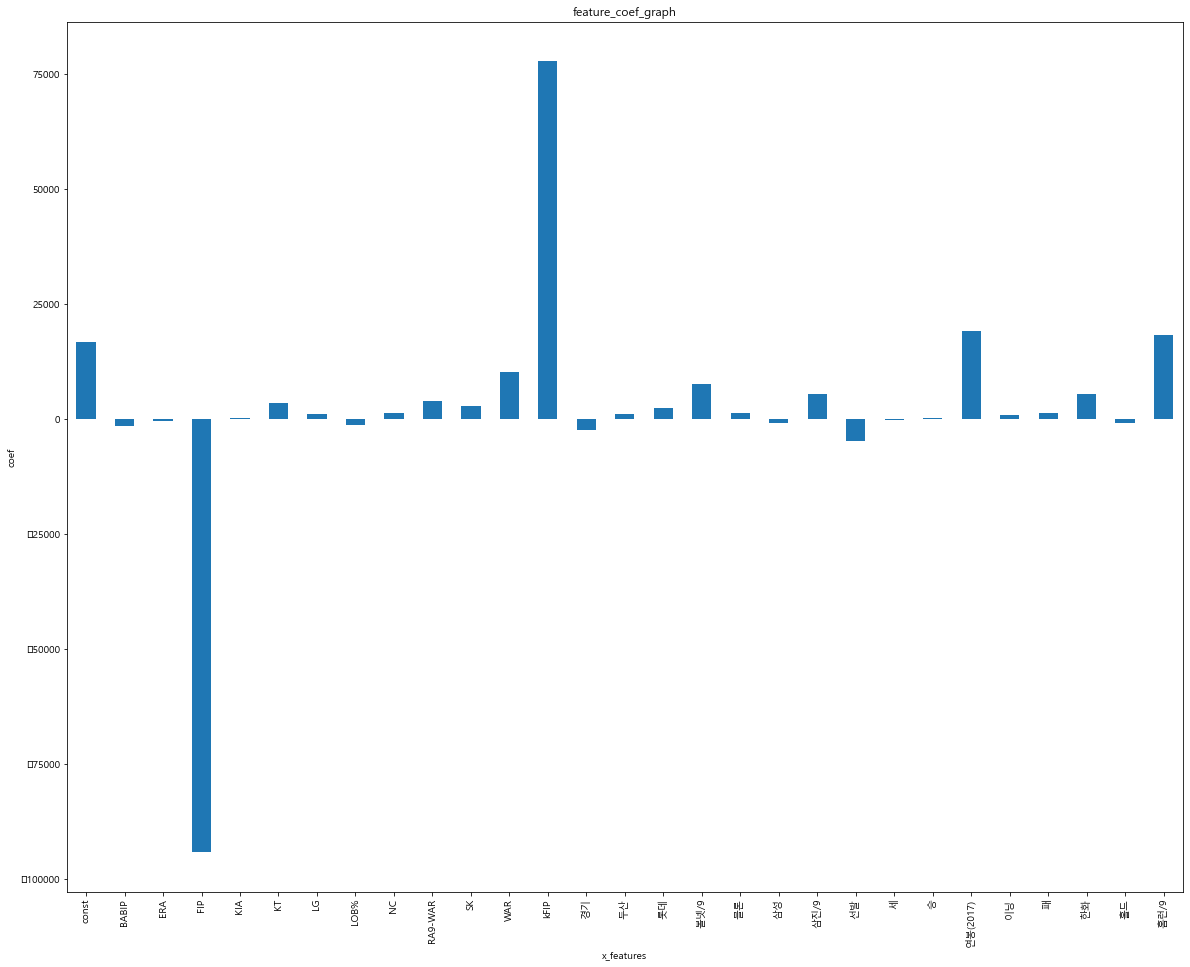

In [26]:
# 한글 출력을 위한 사전 설정 단계입니다.
mpl.rc('font', family='Malgun Gothic')
plt.rcParams['figure.figsize'] = [20, 16]

# 회귀 계수를 리스트로 반환합니다.
coefs = model.params.tolist()
coefs_series = pd.Series(coefs)

# 변수명을 리스트로 반환합니다.
x_labels = model.params.index.tolist()

# 회귀 계수를 출력합니다.
ax = coefs_series.plot(kind='bar')
ax.set_title('feature_coef_graph')
ax.set_xlabel('x_features')
ax.set_ylabel('coef')
ax.set_xticklabels(x_labels)

In [27]:
# 학습 데이터와 테스트 데이터로 분리합니다.
X = picher_df[picher_df.columns.difference(['선수명', 'y'])]
y = picher_df['y']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=19)

In [28]:
# 회귀 분석 모델을 학습합니다.
lr = linear_model.LinearRegression()
model = lr.fit(X_train, y_train)

In [29]:
# 회귀 분석 모델을 평가합니다.
print(model.score(X_train, y_train))    # train R2 score를 출력합니다.
print(model.score(X_test, y_test))      # test R2 score를 출력합니다.

0.9276949405576705
0.8860171644977818


In [30]:
# 회귀 분석 모델을 평가합니다.
y_predictions = lr.predict(X_train)
print(sqrt(mean_squared_error(y_train, y_predictions))) # train RMSE score를 출력합니다.
y_predictions = lr.predict(X_test)
print(sqrt(mean_squared_error(y_test, y_predictions)))  # test RMSE score를 출력합니다.

7282.718684746374
14310.69643688913


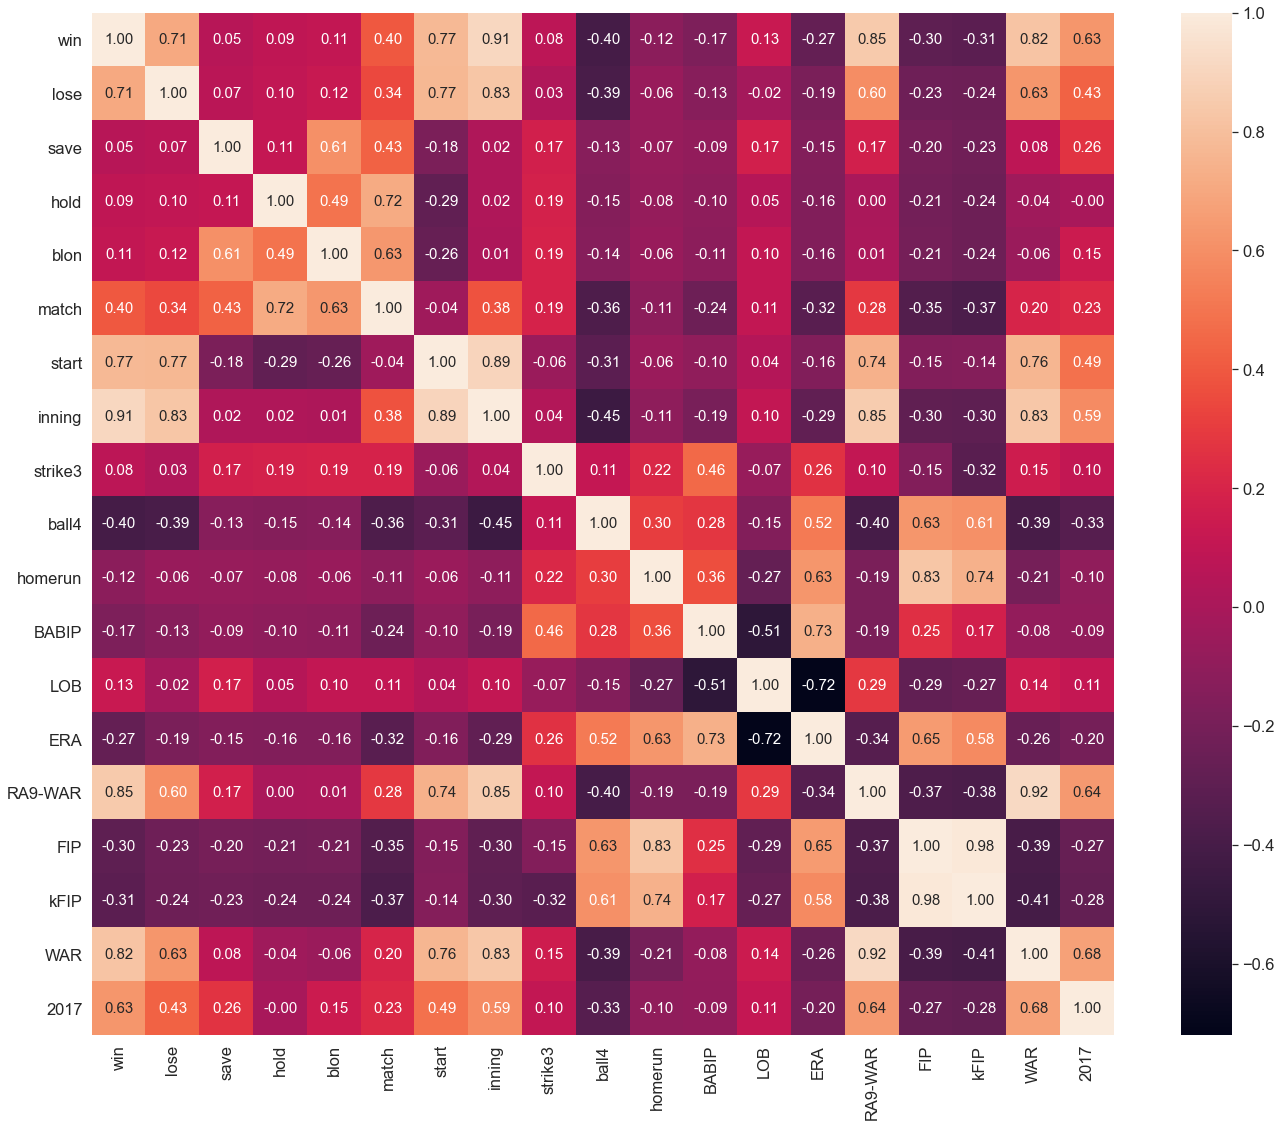

In [31]:
import seaborn as sns

# 피처간의 상관계수 행렬을 계산합니다.
corr = picher_df[scale_columns].corr(method='pearson')
show_cols = ['win', 'lose', 'save', 'hold', 'blon', 'match', 'start', 
             'inning', 'strike3', 'ball4', 'homerun', 'BABIP', 'LOB', 
             'ERA', 'RA9-WAR', 'FIP', 'kFIP', 'WAR', '2017']

# corr 행렬 히트맵을 시각화합니다.
plt.rc('font', family='Malgun Gothic')
sns.set(font_scale=1.5)
hm = sns.heatmap(corr.values,
            cbar=True,
            annot=True, 
            square=True,
            fmt='.2f',
            annot_kws={'size': 15},
            yticklabels=show_cols,
            xticklabels=show_cols)

plt.tight_layout()
plt.show()

In [32]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [33]:
# 피처마다의 VIF 계수를 출력합니다.
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["features"] = X.columns
vif.round(1)

,VIF Factor,features
0,3.2,BABIP
1,10.6,ERA
2,14238.3,FIP
3,1.1,KIA
4,1.1,KT
5,1.1,LG
6,4.3,LOB%
7,1.1,NC
8,13.6,RA9-WAR
9,1.1,SK


In [34]:
# 피처를 재선정합니다.
X = picher_df[['FIP', 'WAR', '볼넷/9', '삼진/9', '연봉(2017)']]
y = picher_df['y']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=19)

In [35]:
# 모델을 학습합니다.
lr = linear_model.LinearRegression()
model = lr.fit(X_train, y_train)

In [36]:
# 결과를 출력합니다.
print(model.score(X_train, y_train))# train R2 score를 출력합니다.
print(model.score(X_test, y_test))      # test R2 score를 출력합니다.

0.9150591192570362
0.9038759653889864


In [37]:
# 회귀 분석 모델을 평가합니다.
y_predictions = lr.predict(X_train)
print(sqrt(mean_squared_error(y_train, y_predictions)))     # train RMSE score를 출력합니다.
y_predictions = lr.predict(X_test)
print(sqrt(mean_squared_error(y_test, y_predictions)))      # test RMSE score를 출력합니다.

7893.462873347692
13141.866063591087


In [38]:
# 피처마다의 VIF 계수를 출력합니다.
X = picher_df[['FIP', 'WAR', '볼넷/9', '삼진/9', '연봉(2017)']]
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["features"] = X.columns
vif.round(1)

,VIF Factor,features
0,1.9,FIP
1,2.1,WAR
2,1.9,볼넷/9
3,1.1,삼진/9
4,1.9,연봉(2017)


In [39]:
# 2018년 연봉을 예측하여 데이터프레임의 column으로 생성합니다.
X = picher_df[['FIP', 'WAR', '볼넷/9', '삼진/9', '연봉(2017)']]
predict_2018_salary = lr.predict(X)
picher_df['예측연봉(2018)'] = pd.Series(predict_2018_salary)

In [40]:
# 원래의 데이터 프레임을 다시 로드합니다.
picher = pd.read_csv(picher_file_path)
picher = picher[['선수명', '연봉(2017)']]

# 원래의 데이터 프레임에 2018년 연봉 정보를 합칩니다.
result_df = picher_df.sort_values(by=['y'], ascending=False)
result_df.drop(['연봉(2017)'], axis=1, inplace=True, errors='ignore')
result_df = result_df.merge(picher, on=['선수명'], how='left')
result_df = result_df[['선수명', 'y', '예측연봉(2018)', '연봉(2017)']]
result_df.columns = ['선수명', '실제연봉(2018)', '예측연봉(2018)', '작년연봉(2017)']

# 재계약하여 연봉이 변화한 선수만을 대상으로 관찰합니다.
result_df = result_df[result_df['작년연봉(2017)'] != result_df['실제연봉(2018)']]
result_df = result_df.reset_index()
result_df = result_df.iloc[:10, :]
result_df.head(10)

,index,선수명,실제연봉(2018),예측연봉(2018),작년연봉(2017)
0,0,양현종,230000,163930.148696,150000
1,1,켈리,140000,120122.822204,85000
2,2,소사,120000,88127.019455,50000
3,4,레일리,111000,102253.697589,85000
4,7,피어밴드,85000,58975.725734,35000
5,13,배영수,50000,56873.662417,55000
6,21,안영명,35000,22420.790838,20000
7,22,채병용,30000,21178.955105,25000
8,23,류제국,29000,45122.360087,35000
9,24,박정진,25000,29060.748299,33000


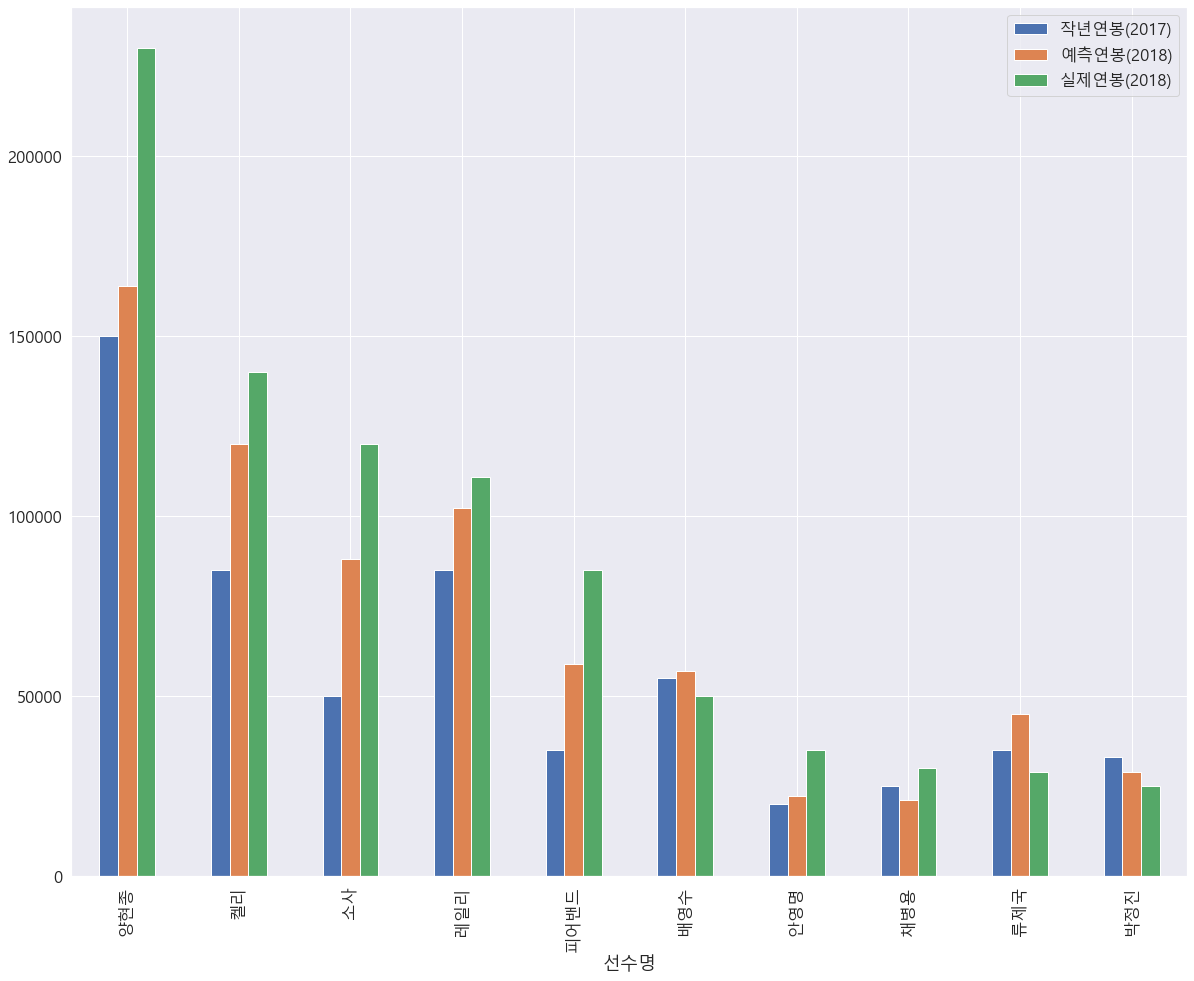

In [41]:
# 선수별 연봉 정보(작년 연봉, 예측 연봉, 실제 연봉)를 bar 그래프로 출력합니다.
mpl.rc('font', family='Malgun Gothic')
result_df.plot(x='선수명', y=['작년연봉(2017)', '예측연봉(2018)', '실제연봉(2018)'], kind="bar")